In [1]:
import os
# 현재 작업 디렉토리 출력
print("현재 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: C:\Users\ict03_012\JupyterNBWorks\finalProject\메모분석_평가분석


In [2]:
import numpy as np
import tensorflow as tf

In [3]:
# 1. 데이터 로드 및 확인
train_text = open('C:/Users/ict03_012/JupyterNBWorks/fML/03_tensorflow2_class/dataset/train.txt', 'rb').read().decode(encoding='utf-8')
test_text = open('C:/Users/ict03_012/JupyterNBWorks/fML/03_tensorflow2_class/dataset/test.txt', 'rb').read().decode(encoding='utf-8')

In [4]:
# 텍스트가 총 몇 자인지 확인합니다.
print('Length of train_text: {} characters'.format(len(train_text)))
print('Length of test_text: {} characters'.format(len(test_text)))
print()

Length of train_text: 6937271 characters
Length of test_text: 2318260 characters



In [5]:
# 처음 300 자를 확인해봅니다.
print(train_text[:300])

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


- 데이타의 각 행은 /t으로 구분되어 있다
- label 에서 0은 부정, 1은 긍정을 의미한다

## 2. 학습을 위한 훈련 데이타와 테스트 데이타 만들기

In [6]:
# 2. 학습을 위한 훈련 데이타와 테스트 데이타 만들기
# 2-1. 정답 데이터(Y)를 먼저 만들기
train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])
print(train_Y.shape, test_Y.shape)
print(train_Y[:5])

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


In [7]:
# 2. 학습을 위한 훈련 데이타와 테스트 데이타 만들기
# 2-2. 훈련 데이터의 입력(X)에 대한 정제(Cleaning) - 불필요한 기호등을 제거
import re

# 각종 기호를 단어와 분리
def clean_str(string):    
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)  # ^ : []안에 포함되지 않은 그 외것을 선택
    # 위 코드로 ,!? 기호 외의 특수 기호 제거 (.은 제거됨)
    # 아래코드는 단어와 붙은 기호를 단어와 분리(하나의 단어처럼 취급하도록 앞 뒤로 공백 추가)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

In [8]:
train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]

In [9]:
# 문장을 띄어쓰기 단위로 단어 분리 ( .,'" 등의 점이 없어짐 )
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


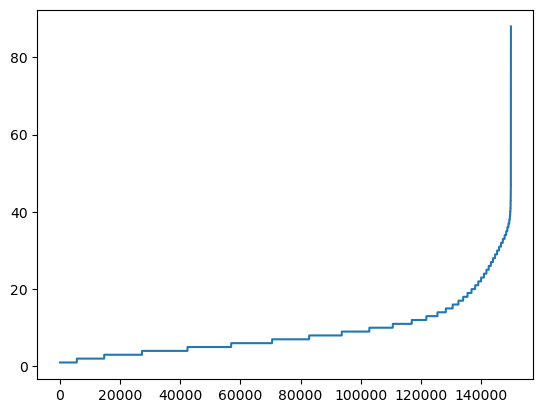

142587


In [10]:
# 2-3. 각 문장의 단어 길이 확인
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

# [결과] 15만개 문장중 40 단어 이하로 주로 구성되어 있음을 확인
#        특히 25단어 이하의 문장이 전체의 142587개로 95% 정도이다.

In [11]:
# 2-4. 단어 정제 및 문장 길이 줄임
#       예를 들어, 스파이더맨, 스파이더맨이, 스파이더맨을, 스파이더맨에게 등등을 5글자로 줄이면 '스파이더맨'이 된다.
sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나']
['너무재밓었']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [12]:
# 2-5. Tokenizer와 pad_sequences를 사용한 문장 전처리
#       Tokenizer(num_words) : 데이터에 출현하는 모든 단어의 갯수를 세고 빈도 수를 정렬하여 num_words 수만큼 반환하고 나머지는 0으로 반환한다.
#                              즉, 빈도 높은 단어순으로 num_words 개 반환
#       tokenizer.fit_on_texts(sentences) : Tokenizer에 데이타를 실제로 입력한다.
#       tokenizer.texts_to_sequences(sentences) : 문장을 입력받아 숫자로 반환
#       pad_sequences() : 입력된 데이터에 패팅을 더함

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)                 # Tokenizer에 데이타를 실제로 입력한다.
train_X = tokenizer.texts_to_sequences(sentences) # 문장을 입력받아 숫자로 반환
train_X = pad_sequences(train_X, padding='post')  # 입력된 데이터에 패팅을 더함 / post: 뒤에, pre: 앞에

print(train_X[:5])

[[   25   884     8  5795  1111     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  588  5796  6697     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   71   346    31    35 10468     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  106  5338     4     2  2169   869   573     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


[결과]

+ '아'글자가 25로 '더빙'은 884라는 숫자로 변경하면서 나머지는 0으로 25개의 리스트됨
+ ['아', '더빙', '진짜', '짜증나네요', '목소리'] 
+ [   25   884     8  5795  1111     0     0     0     0     0     
             0     0      0     0     0     0     0     0     0     0 
             0     0    0     0       0]
             
+ 세번째 문장 '너무재밓었'는 빈도수 20000개에 들지 못하여 0 처리됨
+ 다섯번째 문장에서도 Tokenizer에 의해 걸려져서 0으로 처리됨

In [13]:
# [참고] 위의 Tokenizer의 동작 확인
#       tokenizer.texts_to_sequences(sentences) : 문장을 입력받아 숫자로 반환
#       pad_sequences() : 입력된 데이터에 패팅을 더함

print(tokenizer.index_word[19999])
print(tokenizer.index_word[20000])
temp = tokenizer.texts_to_sequences(['#$#$#', '경우는', '잊혀질', '연기가'])
print(temp)
temp = pad_sequences(temp, padding='post')
print(temp)

# [결과]
#        19999번째 단어 : '경우는',  20000번째 단어 : '잊혀질'
#       확인후 '경우는' -> 19999, '잊혀질' -> 0 으로 된다

경우는
잊혀질
[[], [19999], [], [106]]
[[    0]
 [19999]
 [    0]
 [  106]]


## 3. 모델 정의

   - Embedding 레이어와 LSTM 레이어를 연결한 뒤 마지막으로 Dense 레이어의 softmax 활성화 함수를 사용하여 긍정/부정 분류하는 모델

In [14]:
# 3. 모델 정의 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 300, input_length=25),       # Embedding 레이어 연결
    tf.keras.layers.LSTM(units=50),                               # LSTM 레이어 연결
    tf.keras.layers.Dense(2, activation='softmax')                # Dense 레이어의 softmax 활성화 함수 사용
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
# 임베딩 레이어에서 input_length=25를 지정해서 각 문장에 들어있는 25개 단어를 길이 300의 임베딩벡터로 변환한다.
# 여러 개의 정답 중 하나를 맞추는 분류 문제에서는 categorical_crossentropy를 사용하고, sparse는 정답인 Y가 희소 행렬일 때 사용한다.

C:\Users\ict03_012\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. 모델 학습

In [15]:
#   batch_size : 데이타의 양
#   validation_split : 20%를 검증데이타로 사용
history = model.fit(train_X, train_Y, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.7199 - loss: 0.5122 - val_accuracy: 0.8171 - val_loss: 0.3818
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.8537 - loss: 0.3137 - val_accuracy: 0.8227 - val_loss: 0.3859
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.8779 - loss: 0.2570 - val_accuracy: 0.8196 - val_loss: 0.4288
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8968 - loss: 0.2168 - val_accuracy: 0.8128 - val_loss: 0.4667
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.9096 - loss: 0.1869 - val_accuracy: 0.8055 - val_loss: 0.5450


[결과]

        학습 데이타의 loss는 감소하지만, 검증 데이타의 val_loss는 증가한다.
        이는 과적합이 되고 있다는 것이다.

## 5. 모델 학습 결과를 그래프로 확인

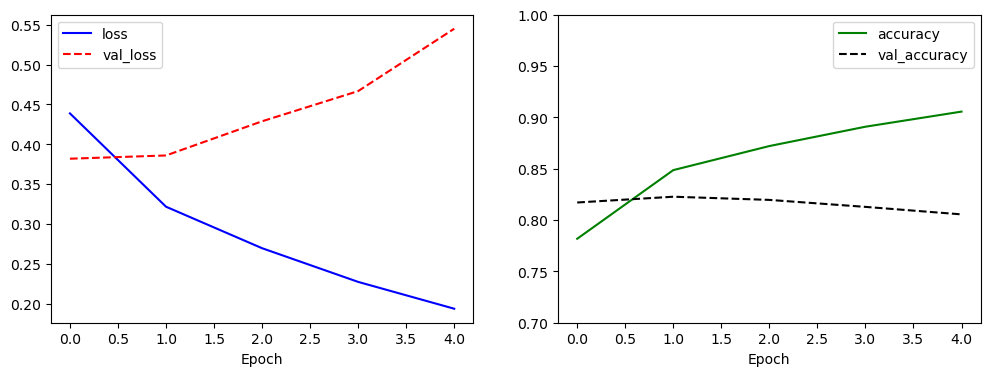

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

[ 결과 ]

그래프를 보면 과적합이 확실하다.

과적합의 이유는 임베딩 레이어를 랜덤한 값에서부터 시작해서 학습시키기 때문에 각 단어를 나타내는 벡터의 품질이 좋지 않기 때문이란다.

이를 개선하기 위한 방법으로는 임베딩 레이어를 별로도 학습시켜서 사용하거나 RNN이 아닌 CNN을 사용하는 방법도 있다.

## 6. 테스트 데이터 평가
- 테스트 데이터는 훈련 데이타와 다르게 어떤 단어가 나올지 모르기에 Tokenizer는 훈련 데이터로만 학습시켜야 한다.

In [17]:
# print(test_text[:100])
# 위의 출력으로 확인해 보니 첫줄을 빼고 개행단위로 한 줄씩 row에 넣은 후
# 단어(\t로 구분)의 갯수가 있는 상태에서만
# 첫단어 id값이 아닌 두번째 단어를 test_text_X 에 지정한다
test_text_X = [row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t') > 0]
test_text_X = [clean_str(sentence) for sentence in test_text_X]
sentences = [sentence.split(' ') for sentence in test_text_X]

sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new

test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding='post')

model.evaluate(test_X, test_Y, verbose=0)
# [결과] 테스트 데이타의 정확도가 80%정도로 검증 데이타의 정확도와 비슷하다.

[0.5514742732048035, 0.8004400134086609]

In [21]:
model.evaluate(test_X, test_Y, verbose=0)

[0.5514742732048035, 0.8004400134086609]

## 7. 임의의 문장 감성 분석 결과 확인

In [18]:
test_sentence = '나름 볼 만한 듯 근데 돈 주고는 안 살듯 후속은 그냥 도서관에서 빌려만 봐야겠다'
test_sentence = test_sentence.split(' ')
test_sentences = []
now_sentence = []
for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])
    
test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding='post', maxlen=25)
prediction = model.predict(test_X_1)
for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print(prediction[idx])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
['나름']
[0.22867645 0.77132356]
['나름', '볼']
[0.306826 0.693174]
['나름', '볼', '만한']
[0.1795591 0.8204409]
['나름', '볼', '만한', '듯']
[0.29847556 0.7015245 ]
['나름', '볼', '만한', '듯', '근데']
[0.19406258 0.80593747]
['나름', '볼', '만한', '듯', '근데', '돈']
[0.23679209 0.7632079 ]
['나름', '볼', '만한', '듯', '근데', '돈', '주고는']
[0.23679209 0.7632079 ]
['나름', '볼', '만한', '듯', '근데', '돈', '주고는', '안']
[0.24747728 0.75252265]
['나름', '볼', '만한', '듯', '근데', '돈', '주고는', '안', '살듯']
[0.24747728 0.75252265]
['나름', '볼', '만한', '듯', '근데', '돈', '주고는', '안', '살듯', '후속은']
[0.24747728 0.75252265]
['나름', '볼', '만한', '듯', '근데', '돈', '주고는', '안', '살듯', '후속은', '그냥']
[0.30479896 0.695201  ]
['나름', '볼', '만한', '듯', '근데', '돈', '주고는', '안', '살듯', '후속은', '그냥', '도서관에서']
[0.37974998 0.62025   ]
['나름', '볼', '만한', '듯', '근데', '돈', '주고는', '안', '살듯', '후속은', '그냥', '도서관에서', '빌려만']
[0.37974998 0.62025   ]
['나름', '볼', '만한', '듯', '근데', '돈', '주고는', '안', '살듯', '후속은', '그냥', '도서관에서', '빌려만', '봐야겠다']
[0.45621574 0.5437842 ]


## 8. 모델 저장

In [19]:
model.save('감정분석모델_원본.keras')